In [87]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv('train.csv',dtype={"Age": np.float64})
test = pd.read_csv('test.csv',dtype={"Age": np.float64})
PassengerId=test['PassengerId']
all_data = pd.concat([train, test], ignore_index = True)

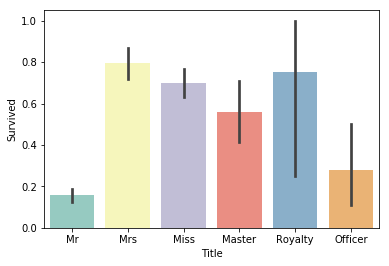

In [88]:
all_data['Title'] = all_data['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip())
Title_Dict = {}
Title_Dict.update(dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer'))
Title_Dict.update(dict.fromkeys(['Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty'))
Title_Dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
Title_Dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
Title_Dict.update(dict.fromkeys(['Mr'], 'Mr'))
Title_Dict.update(dict.fromkeys(['Master','Jonkheer'], 'Master'))
all_data['Title'] = all_data['Title'].map(Title_Dict)
sns.barplot(x="Title", y="Survived", data=all_data, palette='Set3')

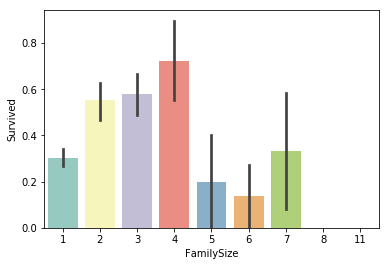

In [89]:
all_data['FamilySize']=all_data['SibSp']+all_data['Parch']+1
sns.barplot(x="FamilySize", y="Survived", data=all_data, palette='Set3')

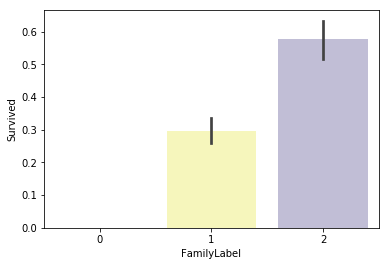

In [90]:
def Fam_label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 7)) | (s == 1):
        return 1
    elif (s > 7):
        return 0
all_data['FamilyLabel']=all_data['FamilySize'].apply(Fam_label)
sns.barplot(x="FamilyLabel", y="Survived", data=all_data, palette='Set3')

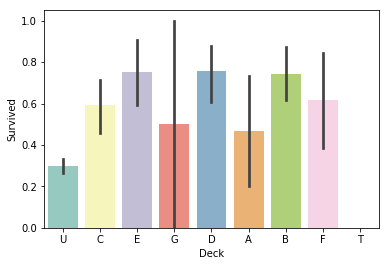

In [91]:
all_data['Cabin'] = all_data['Cabin'].fillna('Unknown')
all_data['Deck']=all_data['Cabin'].str.get(0)
sns.barplot(x="Deck", y="Survived", data=all_data, palette='Set3')

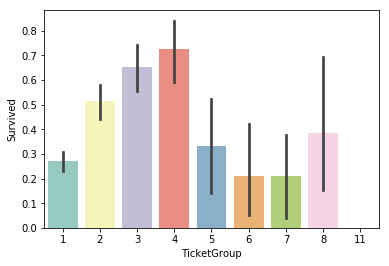

In [92]:
Ticket_Count = dict(all_data['Ticket'].value_counts())
all_data['TicketGroup'] = all_data['Ticket'].apply(lambda x:Ticket_Count[x])
sns.barplot(x='TicketGroup', y='Survived', data=all_data, palette='Set3')

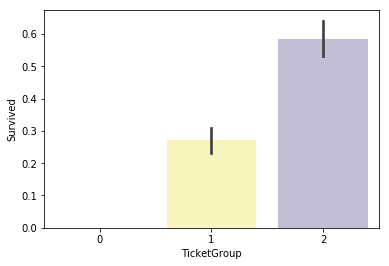

In [93]:
def Ticket_Label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 8)) | (s == 1):
        return 1
    elif (s > 8):
        return 0

all_data['TicketGroup'] = all_data['TicketGroup'].apply(Ticket_Label)
sns.barplot(x='TicketGroup', y='Survived', data=all_data, palette='Set3')

In [94]:
age_df = all_data[['Age', 'Pclass','Sex','Title']]
age_df=pd.get_dummies(age_df)
known_age = age_df[age_df.Age.notnull()].as_matrix()
unknown_age = age_df[age_df.Age.isnull()].as_matrix()
y = known_age[:, 0]
X = known_age[:, 1:]
rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X, y)
predictedAges = rfr.predict(unknown_age[:, 1::])
all_data.loc[ (all_data.Age.isnull()), 'Age' ] = predictedAges 

In [95]:
all_data['Embarked'] = all_data['Embarked'].fillna('C')

In [96]:
fare=all_data[(all_data['Embarked'] == "S") & (all_data['Pclass'] == 3)].Fare.median()
all_data['Fare']=all_data['Fare'].fillna(fare)


In [97]:
all_data['Surname']=all_data['Name'].apply(lambda x:x.split(',')[0].strip())
Surname_Count = dict(all_data['Surname'].value_counts())
all_data['FamilyGroup'] = all_data['Surname'].apply(lambda x:Surname_Count[x])
Female_Child_Group=all_data.loc[(all_data['FamilyGroup']>=2) & ((all_data['Age']<=12) | (all_data['Sex']=='female'))]
Male_Adult_Group=all_data.loc[(all_data['FamilyGroup']>=2) & (all_data['Age']>12) & (all_data['Sex']=='male')]

Female_Child=pd.DataFrame(Female_Child_Group.groupby('Surname')['Survived'].mean().value_counts())
Female_Child.columns=['GroupCount']
Female_Child

,GroupCount
1.000000,115
0.000000,31
0.750000,2
0.333333,1
0.142857,1


In [98]:
Male_Adult=pd.DataFrame(Male_Adult_Group.groupby('Surname')['Survived'].mean().value_counts())
Male_Adult.columns=['GroupCount']
Male_Adult

,GroupCount
0.000000,122
1.000000,20
0.500000,6
0.333333,2
0.250000,1


In [99]:
Female_Child_Group=Female_Child_Group.groupby('Surname')['Survived'].mean()
Dead_List=set(Female_Child_Group[Female_Child_Group.apply(lambda x:x==0)].index)
print(Dead_List)
Male_Adult_List=Male_Adult_Group.groupby('Surname')['Survived'].mean()
Survived_List=set(Male_Adult_List[Male_Adult_List.apply(lambda x:x==1)].index)
print(Survived_List)

{'Panula', 'Lefebre', 'Skoog', 'Rosblom', 'Arnold-Franchi', 'Lobb', 'Danbom', 'Zabour', 'Vander Planke', 'Boulos', 'Palsson', 'Ilmakangas', 'Sage', 'Attalah', 'Strom', 'Goodwin', 'Lahtinen', 'Caram', 'Oreskovic', 'Turpin', 'Cacic', 'Rice', 'Robins', 'Johnston', 'Jussila', 'Barbara', 'Olsson', 'Van Impe', 'Canavan', 'Ford', 'Bourke'}
{'Frolicher-Stehli', 'Kimball', 'Daly', 'Frauenthal', 'Bradley', 'Jonsson', 'Cardeza', 'Dick', 'Duff Gordon', 'Bishop', 'Harder', 'Jussila', 'McCoy', 'Beane', 'Taylor', 'Nakid', 'Beckwith', 'Greenfield', 'Chambers', 'Goldenberg'}


In [100]:
Ti_pred = all_data.groupby('Title')['Age'].median().values
all_data['Ti_Age'] = all_data['Age']

# Filling the missing age
for i in range(0,6):
 # 0 1 2 3 4 5 6
    all_data.loc[(all_data.Age.isnull()) & (all_data.Title == i),'Ti_Age'] = Ti_pred[i]
all_data['Ti_Age'] = all_data['Ti_Age'].astype('int')
all_data['Ti_Minor'] = ((all_data['Ti_Age']) < 16.0) * 1 
all_data['Ti_Minor'].unique()

array([0, 1], dtype=int64)

In [101]:
train=all_data.loc[all_data['Survived'].notnull()]
test=all_data.loc[all_data['Survived'].isnull()]
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Sex'] = 'male'
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Age'] = 60
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Title'] = 'Mr'
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Sex'] = 'female'
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Age'] = 5
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Title'] = 'Miss'

In [102]:
all_data=pd.concat([train, test])
all_data=all_data[['Survived','Pclass','Sex','Age','Fare','Embarked','Title','FamilyLabel','Deck','TicketGroup']]
all_data=pd.get_dummies(all_data)
train=all_data[all_data['Survived'].notnull()]
test=all_data[all_data['Survived'].isnull()].drop('Survived',axis=1)
X = train.as_matrix()[:,1:]
y = train.as_matrix()[:,0]

In [85]:
pipe=Pipeline([('select',SelectKBest(k=20)), 
               ('classify', RandomForestClassifier(
                   random_state = 10, max_features = 'sqrt'))])

param_test = {'classify__n_estimators':list(range(20,50,2)), 
              'classify__max_depth':list(range(3,60,3))}
gsearch = GridSearchCV(estimator = pipe, param_grid = param_test, scoring='roc_auc', cv=10)
gsearch.fit(X,y)
print(gsearch.best_params_, gsearch.best_score_)

KeyboardInterrupt: 

In [103]:
select = SelectKBest(k = 20) #keep the k features with higher scores
clf = RandomForestClassifier(random_state = 10, warm_start = True, 
                                  n_estimators = 26,
                                  max_depth = 6, 
                                  max_features = 'sqrt')
pipeline = make_pipeline(select, clf)
pipeline.fit(X, y)

Pipeline(memory=None,
     steps=[('selectkbest', SelectKBest(k=20, score_func=<function f_classif at 0x000001B505B6A7B8>)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decreas...estimators=26, n_jobs=1,
            oob_score=False, random_state=10, verbose=0, warm_start=True))])

In [104]:
cv_score = cross_validation.cross_val_score(pipeline, X, y, cv= 10)
print("CV Score : Mean - %.7g | Std - %.7g " % (np.mean(cv_score), np.std(cv_score)))
#n_estimators = 26, Mean - 0.8451402 | Std - 0.03276752 
#n_estimators = 42, Mean - 0.8406078 | Std - 0.038599 
#n_estimators = 26,-Age, Mean - 0.8327676 | Std - 0.04096656  
#n_estimators = 26,+Ti_Minor, Mean - 0.8293968 | Std - 0.0401431  

CV Score : Mean - 0.8451402 | Std - 0.03276752 


In [19]:
predictions = pipeline.predict(test)
submission = pd.DataFrame({"PassengerId": PassengerId, "Survived": predictions.astype(np.int32)})
submission.to_csv("submission.csv", index=False)

In [22]:
#Your submission scored 0.83732, which is an improvement of 
#your previous score of 0.82296. Great job!


SelectKBest(k=20, score_func=<function f_classif at 0x000001B505B6A7B8>)